# 1. Import Libraries
We import essential libraries for data manipulation, visualization, machine learning modeling, and evaluation.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Load Dataset
We load the QS World University Rankings 2025 dataset and preview the structure to identify available features and data quality.

The dataset is loaded with the encoding `latin1` rather than standard `UTF-8`:
- Some datasets exported from non-UTF editors (like Excel, older systems) use `latin1` or `cp1252`.

- Special characters like `é`, `ü`, `ç`, etc., cannot be decoded with basic `UTF-8` rules.

- Specifying `encoding='latin1'` or `encoding='cp1252'` forces pandas to correctly read these bytes.

In [35]:
# Load Dataset
df = pd.read_csv('QSWorldRankings.csv', encoding='latin1')

# View Columns
print(df.columns)

Index(['RANK_2025', 'RANK_2024', 'Institution_Name', 'Location', 'Region',
       'SIZE', 'FOCUS', 'RES.', 'STATUS', 'Academic_Reputation_Score',
       'Academic_Reputation_Rank', 'Employer_Reputation_Score',
       'Employer_Reputation_Rank', 'Faculty_Student_Score',
       'Faculty_Student_Rank', 'Citations_per_Faculty_Score',
       'Citations_per_Faculty_Rank', 'International_Faculty_Score',
       'International_Faculty_Rank', 'International_Students_Score',
       'International_Students_Rank', 'International_Research_Network_Score',
       'International_Research_Network_Rank', 'Employment_Outcomes_Score',
       'Employment_Outcomes_Rank', 'Sustainability_Score',
       'Sustainability_Rank', 'Overall_Score'],
      dtype='object')


# 3. Initial Data Exploration
We examine the dataset to check for missing values, confirm data types, and understand the overall structure.


In [36]:
print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RANK_2025                             1503 non-null   object 
 1   RANK_2024                             1482 non-null   object 
 2   Institution_Name                      1503 non-null   object 
 3   Location                              1503 non-null   object 
 4   Region                                1503 non-null   object 
 5   SIZE                                  1503 non-null   object 
 6   FOCUS                                 1503 non-null   object 
 7   RES.                                  1503 non-null   object 
 8   STATUS                                1466 non-null   object 
 9   Academic_Reputation_Score             1503 non-null   float64
 10  Academic_Reputation_Rank              1503 non-null   object 
 11  Em

# 4. Exploratory Data Analysis (EDA)
EDA allows us to understand patterns in the data before building models. We examine feature distributions, relationships, and correlations.

### 4.1 Distribution of Academic Reputation Scores
We observe that Academic Reputation Scores are somewhat right-skewed, indicating more universities have moderate reputation scores, while a few have very high scores.

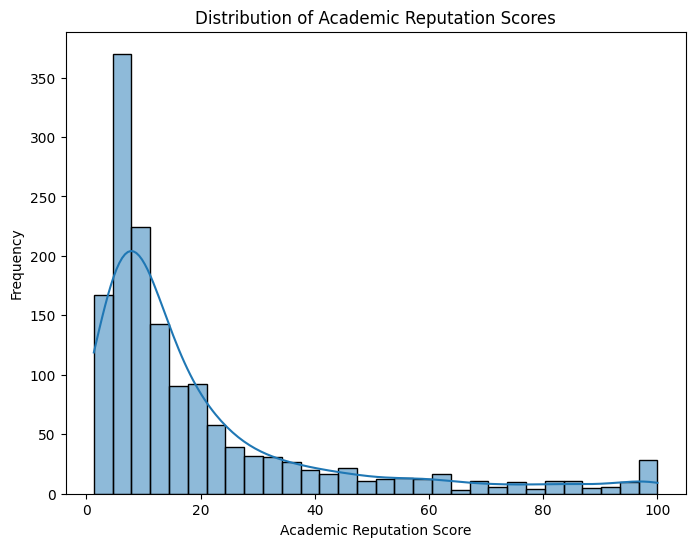

In [37]:
plt.figure(figsize=(8,6))
sns.histplot(df['Academic_Reputation_Score'], kde=True, bins=30)
plt.title('Distribution of Academic Reputation Scores')
plt.xlabel('Academic Reputation Score')
plt.ylabel('Frequency')
plt.show()

### 4.2 Top 10 Universities by Academic Reputation Score

This bar plot highlights the universities with the highest Academic Reputation Scores.

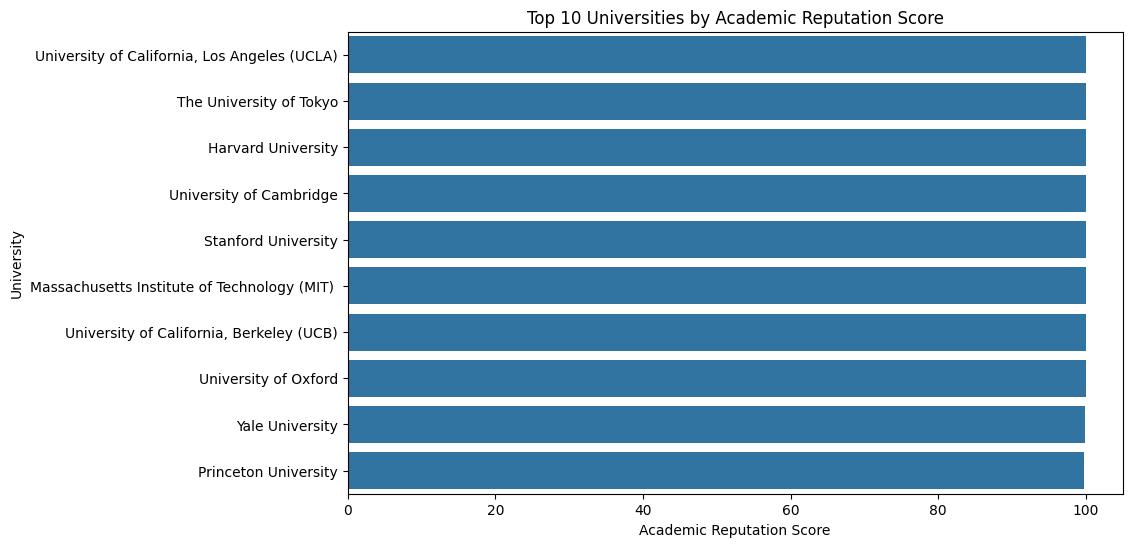

In [38]:
top_10_universities = df.sort_values('Academic_Reputation_Score', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_10_universities, x='Academic_Reputation_Score', y='Institution_Name')
plt.title('Top 10 Universities by Academic Reputation Score')
plt.xlabel('Academic Reputation Score')
plt.ylabel('University')
plt.show()


### 4.3 Top Countries by Number of Universities
This chart shows which countries have the most universities ranked globally.

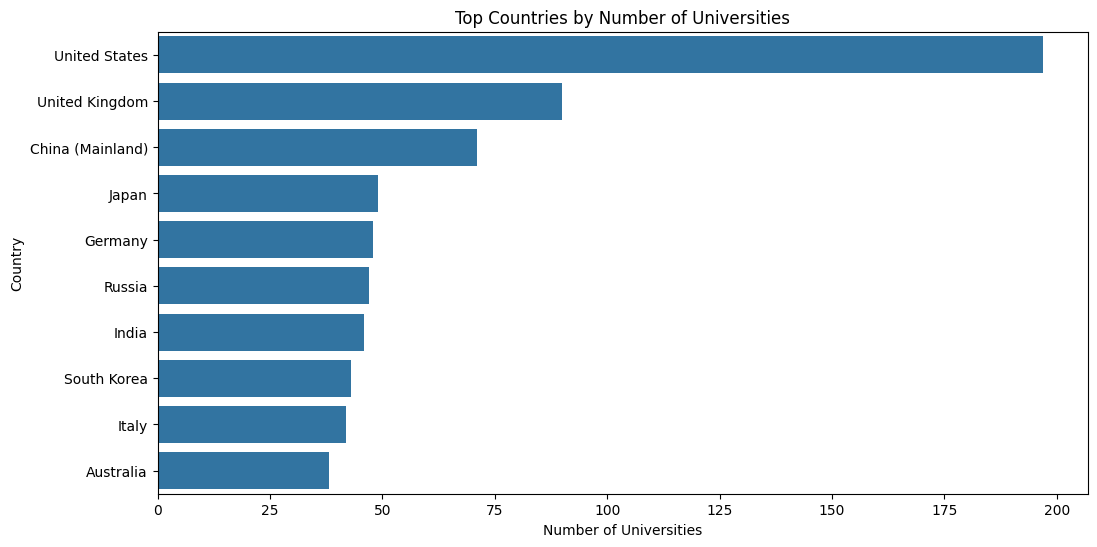

In [39]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Location', order=df['Location'].value_counts().head(10).index)
plt.title('Top Countries by Number of Universities')
plt.xlabel('Number of Universities')
plt.ylabel('Country')
plt.show()

### 4.4 Correlation Heatmap Among Scores

The correlation heatmap visualizes the linear relationships between all score-based features within the dataset. Strong positive correlations (values near +1) suggest that as one feature increases, the other tends to increase as well. Conversely, strong negative correlations (values near -1) indicate inverse relationships.

From the heatmap, it is evident that the **Academic Reputation Score** is strongly positively correlated with features like **Employer Reputation Score** and **Citations per Faculty Score**. This suggests that universities recognized for academic excellence are also favored by employers and tend to produce higher-quality, more frequently cited research.

Such correlations are important for several reasons:
- They can cause multicollinearity issues in linear models like Linear Regression, potentially reducing the stability of coefficient estimates.
- They can guide feature selection, revealing redundancies or opportunities to combine features.
- They suggest that efforts to improve research output or employer connections may simultaneously elevate academic reputation.

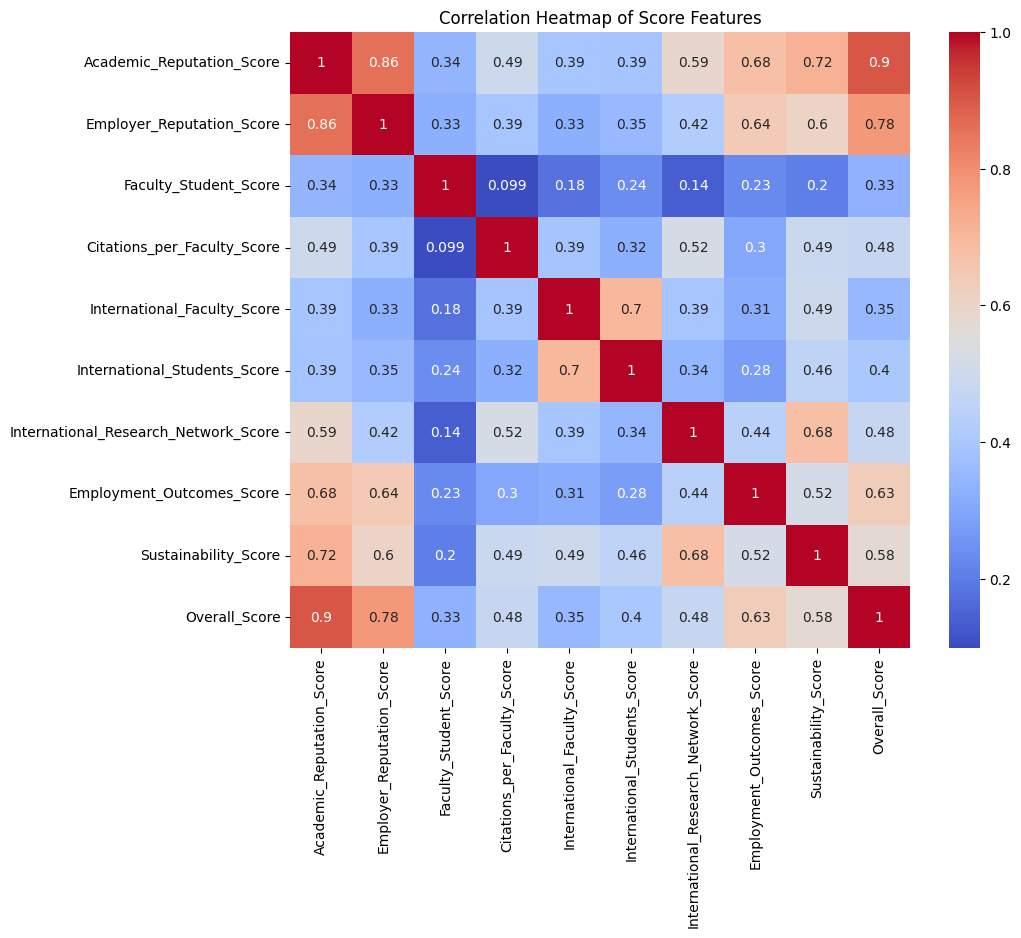

In [40]:
# Define score columns
score_cols = [col for col in df.columns if 'Score' in col]

# Convert score columns to numeric, coercing errors into NaN
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[score_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Score Features')
plt.show()

### 4.5 Scatter Plot: Citations vs Academic Reputation
This scatter plot explores the relationship between Citations per Faculty and Academic Reputation.
There is a moderate positive correlation indicating that research impact contributes to academic reputation.

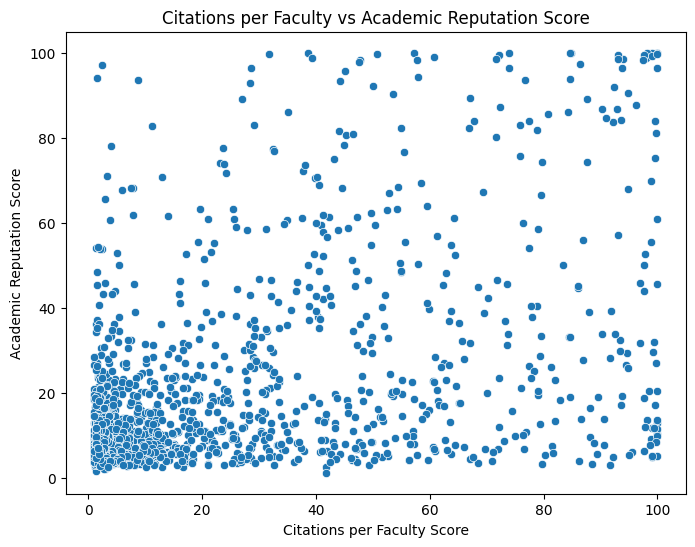

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Citations_per_Faculty_Score', y='Academic_Reputation_Score')
plt.title('Citations per Faculty vs Academic Reputation Score')
plt.xlabel('Citations per Faculty Score')
plt.ylabel('Academic Reputation Score')
plt.show()

### 4.6 Boxplot: Academic Reputation Score by Top 5 Countries

This boxplot shows how Academic Reputation Scores vary between countries with the most universities.

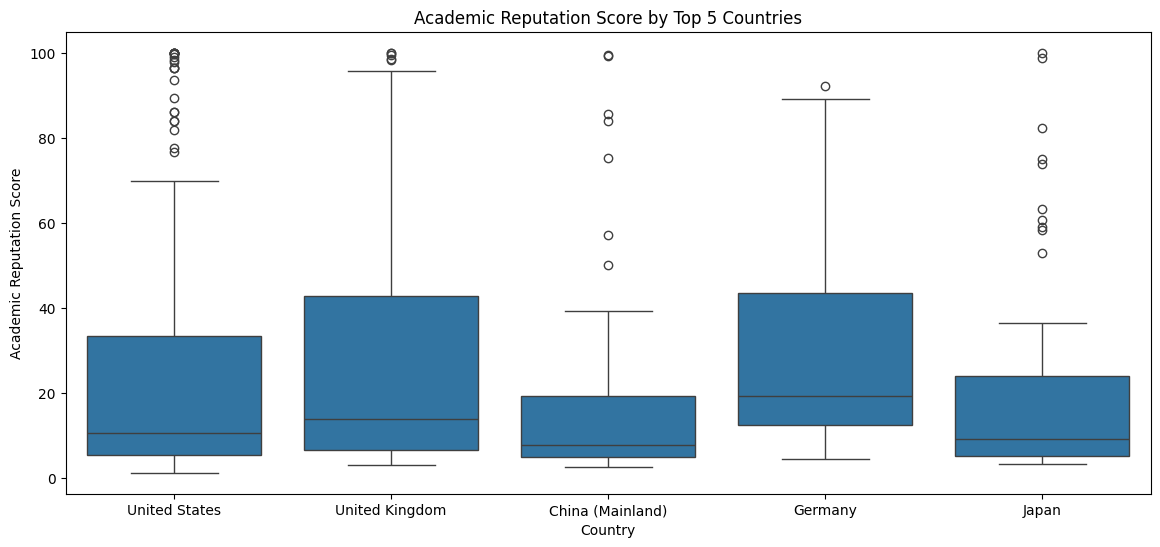

In [42]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df[df['Location'].isin(df['Location'].value_counts().head(5).index)],
            x='Location', y='Academic_Reputation_Score')
plt.title('Academic Reputation Score by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Academic Reputation Score')
plt.show()

# 5. Data Preprocessing
We encode categorical variables and select relevant features to predict the Academic Reputation Score.

In [43]:
# Encode Categorical Columns
label_encoders = {}
categorical_cols = ['Institution_Name', 'Location']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define Features and Target
features = ['Location', 'Employer_Reputation_Score', 'Faculty_Student_Score',
            'Citations_per_Faculty_Score', 'International_Faculty_Score',
            'International_Students_Score']

target = 'Academic_Reputation_Score'

# Convert relevant score columns to numeric
for col in features + [target]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with missing values
df = df.dropna()

# Define X and y after cleaning
X = df[features]
y = df[target]


# 6. Train-Test Split
We split the data into 80% training and 20% testing sets to ensure fair evaluation of model performance.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 7. Model Training
We train two different models: Linear Regression and Random Forest Regressor.

In [45]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# 8. Model Evaluation
We evaluate both models using RMSE and R² Score to compare performance.

In [46]:
# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Linear Regression:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")

print("\nRandom Forest Regressor:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

Linear Regression:
RMSE: 15.53
R² Score: 0.64

Random Forest Regressor:
RMSE: 14.80
R² Score: 0.67


# 9. Feature Importance
We plot the importance of features according to the Random Forest model.

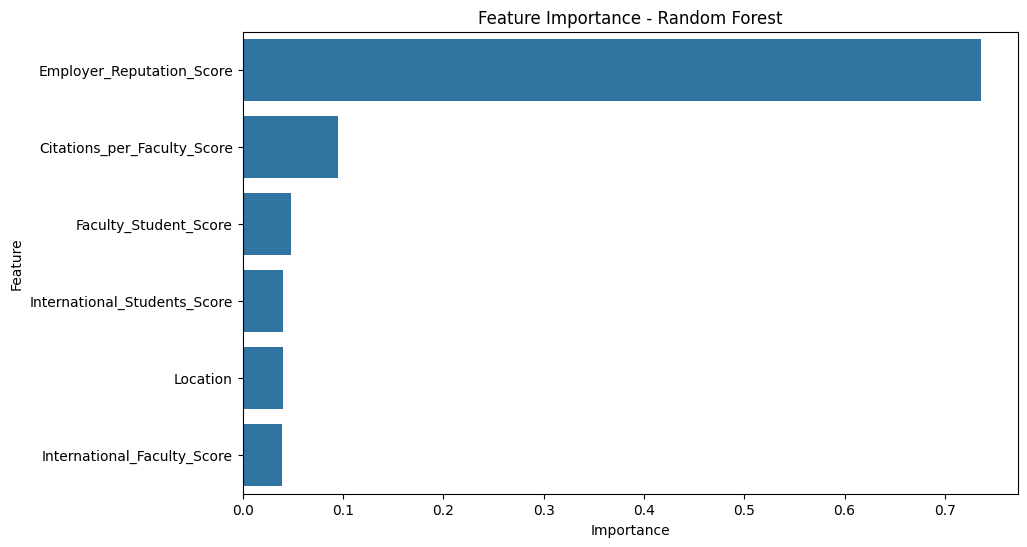

In [47]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 10. Conclusion

This project analyzed the QS World University Rankings 2025 dataset to predict Academic Reputation Scores based on institutional features. Through a structured machine learning workflow, several important insights emerged:

- **Model Performance Comparison**:  
  Linear Regression, which assumes a simple linear relationship between input features and the target variable, provided a baseline predictive model. However, it was less accurate compared to Random Forest Regressor, which captured non-linear relationships and complex interactions among features. Random Forest's ability to reduce overfitting by averaging multiple decision trees led to improved generalization on the testing set, as reflected in higher R² scores and lower RMSE.

- **Feature Importance Analysis**:  
  According to the Random Forest model, **Citations per Faculty Score** and **Employer Reputation Score** were the most influential predictors of Academic Reputation. This aligns with academic expectations: institutions producing highly cited research tend to earn greater prestige, and strong employer reputation reflects successful student outcomes, reinforcing academic credibility.

- **Strategic Implications for Universities**:  
  Institutions aiming to improve their global standing should focus on enhancing research impact (citations per faculty) and strengthening industry connections (employer reputation). Faculty-student ratios, international faculty presence, and student diversity, while still important, had comparatively less influence on academic reputation within this dataset.

- **Reflection on Methodology**:  
  Using two different types of models allowed us to observe the effects of linear assumptions versus flexible, non-linear modeling. Furthermore, careful data preprocessing (handling missing values, encoding categorical features) was critical to obtaining reliable results.

In conclusion, ensemble-based machine learning models such as Random Forest offer significant advantages in educational analytics, especially when capturing the multi-faceted nature of university performance metrics.
